# FNO implementation
1980 -2026 \
inputs: SSH, u_curr, v_curr, SLP, u_wind, v_wind, bathy \
outputs: SSH_(t+Δt), u_curr_(t+Δt), v_curr_(t+Δt)

## Import necessary lib

In [2]:
import torch
import torch.nn as nn
import torch.fft
import matplotlib.pyplot as plt
import numpy as np
import os
from neuralop.models import FNO
import xarray as xr

In [16]:
data_forcing_jan = xr.open_dataset('data\\fno_ERA5forcing_y1980m01.nc')
data_forcing_feb = xr.open_dataset('data\\fno_ERA5forcing_y1980m02.nc')
data_forcing_mar = xr.open_dataset('data\\fno_ERA5forcing_y1980m03.nc')
data_forcing_apr = xr.open_dataset('data\\fno_ERA5forcing_y1980m04.nc')
data_forcing_may = xr.open_dataset('data\\fno_ERA5forcing_y1980m05.nc')
data_forcing_jun = xr.open_dataset('data\\fno_ERA5forcing_y1980m06.nc')
data_forcing_jul = xr.open_dataset('data\\fno_ERA5forcing_y1980m07.nc')
data_forcing_aug = xr.open_dataset('data\\fno_ERA5forcing_y1980m08.nc')
data_forcing_sep = xr.open_dataset('data\\fno_ERA5forcing_y1980m09.nc')
data_forcing_oct = xr.open_dataset('data\\fno_ERA5forcing_y1980m10.nc')
data_forcing_nov = xr.open_dataset('data\\fno_ERA5forcing_y1980m11.nc')
data_forcing_dc = xr.open_dataset('data\\fno_ERA5forcing_y1980m12.nc')

data_ssh = xr.open_dataset('data\\NAA10KM_1h_19800101_19801231_ssh.nc') # Sea surface height
data_ubar = xr.open_dataset('data\\NAA10KM_1h_19800101_19801231_ubar.nc') # U
data_vbar = xr.open_dataset('data\\NAA10KM_1h_19800101_19801231_vbar.nc') # V
data_bath = xr.open_dataset('data\\nordic_seas_domain_cfg.nc')
data_forcing_jan

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 248, lat: 241, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1980-01-01 ... 1980-01-31T21:00:00
  * lat      (lat) float32 964B 90.0 89.75 89.5 89.25 ... 30.75 30.5 30.25 30.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Data variables:
    msl      (time, lat, lon) float32 344MB ...
    u10      (time, lat, lon) float32 344MB ...
    v10      (time, lat, lon) float32 344MB ...
Attributes:
    CDI:                        Climate Data Interface version ?? (http://mpi...
    Conventions:                CF-1.6
    CDO:                        Climate Data Operators version 1.9.3 (http://...
    institution:                ECMWF
    NCO:                        netCDF Operators version 5.1.9 (Homepage = ht...
    history:                    Wed Jan 21 10:07:09 2026: ncks -A -v v10 ERA5...
    history_of_appended_files:  Wed Jan 21 10:07:09 2026: Appended file ERA5f...

In [20]:
def find_coords(ds):
    # try common names
    for cand in ('lat','latitude','y','nav_lat'):
        if cand in ds.coords: return ds[cand].values, cand
    # try scanning 1D coords
    for name, coord in ds.coords.items():
        if coord.ndim == 1:
            arr = coord.values
            if np.all(np.isfinite(arr)):
                # Heuristic: lat range ~ -90..90
                if arr.min() >= -90 and arr.max() <= 90:
                    return arr, name
    raise KeyError('lat coord not found')

def find_lon(ds):
    for cand in ('lon','longitude','x','nav_lon'):
        if cand in ds.coords: return ds[cand].values, cand
    for name, coord in ds.coords.items():
        if coord.ndim == 1:
            arr = coord.values
            if np.all(np.isfinite(arr)):
                if arr.ptp() > 0:
                    return arr, name
    raise KeyError('lon coord not found')

lat_ssh, lat_name = find_coords(data_ssh)
lon_ssh, lon_name = find_lon(data_ssh)
print('SSH coords:', lat_ssh, lon_ssh)

SSH coords: [[60.495556 60.49752  60.499317 ... 57.200256 57.17408  57.147858]
 [60.588005 60.589996 60.59182  ... 57.27585  57.249527 57.223164]
 [60.68035  60.682373 60.684223 ... 57.35131  57.324852 57.298344]
 ...
 [84.01037  84.03515  84.05881  ... 72.09418  72.02331  71.95251 ]
 [84.090965 84.11611  84.14013  ... 72.11516  72.04416  71.97322 ]
 [84.17148  84.197    84.221375 ... 72.13577  72.06464  71.993576]] [[-29.022478 -28.834631 -28.646717 ...  10.053447  10.192925  10.332043]
 [-29.026667 -28.838484 -28.650232 ...  10.101908  10.241437  10.380605]
 [-29.030926 -28.842402 -28.65381  ...  10.15073   10.290311  10.429528]
 ...
 [-41.591915 -40.815784 -40.03307  ...  45.12009   45.18856   45.256336]
 [-41.83817  -41.052204 -40.259384 ...  45.351048  45.418423  45.485107]
 [-42.091503 -41.295483 -40.49232  ...  45.582703  45.648968  45.714558]]


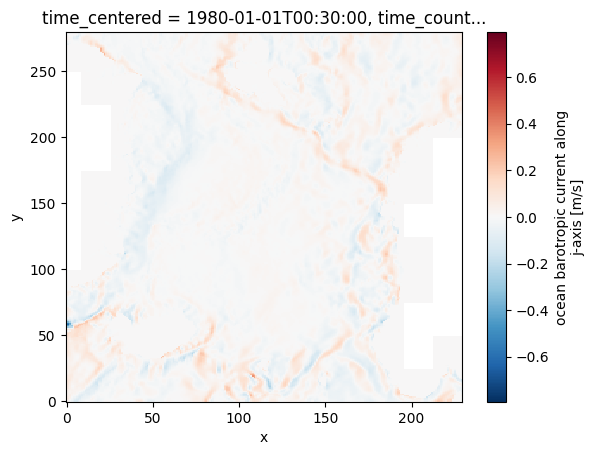

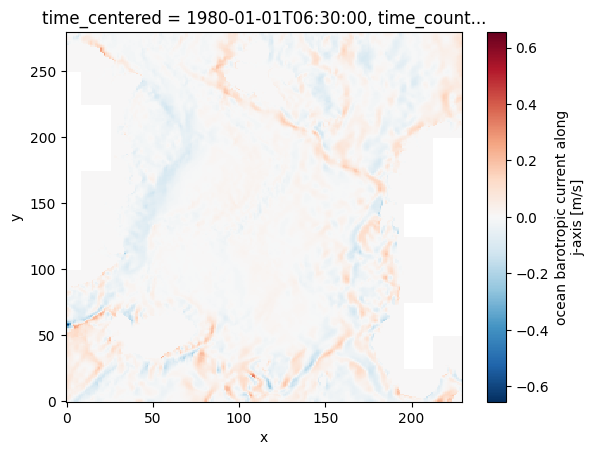

In [9]:
for i in range(0, 7, 6):
    data_vbar["vbar"].isel(time_counter=i).plot()
    plt.show()

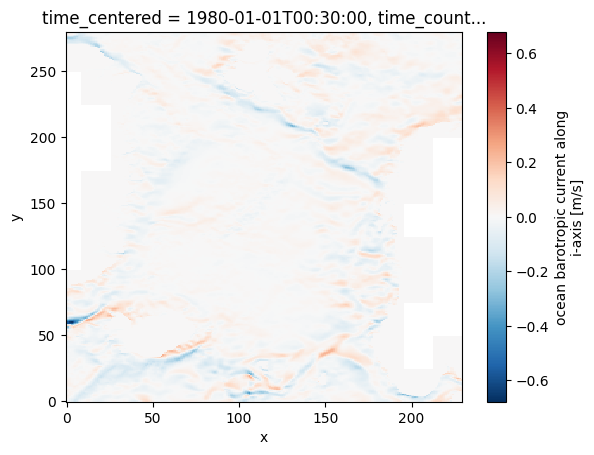

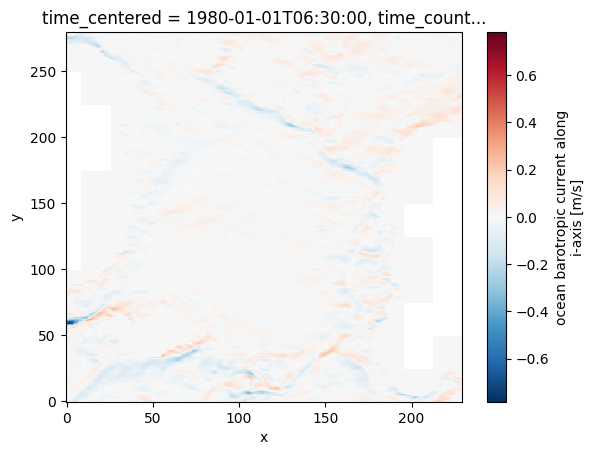

In [10]:
for i in range(0, 7, 6):
    data_ubar["ubar"].isel(time_counter=i).plot()
    plt.show()

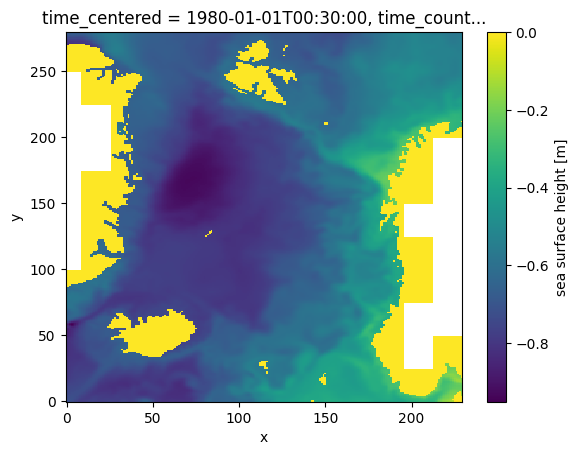

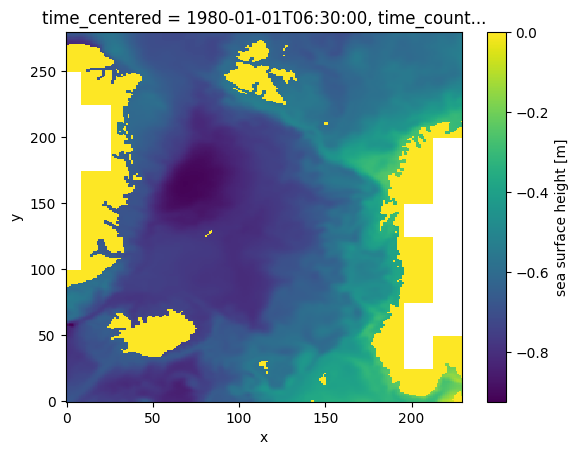

In [ ]:
data_ssh["ssh"].isel(time_counter=0).plot()
plt.show()

objective: emulating barotropic ocean currents (u, v) and sea surface height (ssh) of the next time step.
inputs: U10, v10, msl, bathymetry, and previous state of the ocean (u, v, ssh)

In [18]:
target = data_ssh

print(target['ssh'].lat, target['ssh'].lon)

AttributeError: 'DataArray' object has no attribute 'lat'